<a href="https://colab.research.google.com/github/UdayVT/Black-Scholes-Neural-Network/blob/main/Black_Scholes_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.stats import norm

import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, LeakyReLU, Dropout
from keras import backend
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import get_custom_objects
from keras import backend as K
from keras.activations import elu, sigmoid
import tensorflow as tf

In [56]:
N = norm.cdf
def BS_CALL(S, K, T, r, q , sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*(math.exp(-q*T))* N(d1) - K * np.exp(-r*T)* N(d2)

In [57]:
price = np.random.uniform(10, 20, 300000)
strike = np.random.uniform(10, 20, 300000)
time = np.random.uniform(0.1, 3, 300000)
intrest = np.random.uniform(0.01, 0.03, 300000)
divident = np.random.uniform(0, 0.03, 300000)
volatility = np.random.uniform(0.05, 0.3, 300000)
call = np.zeros(300000)

In [58]:
for i in range(0,300000):
  call[i] = BS_CALL(price[i],strike[i],time[i],intrest[i],divident[i],volatility[i])

In [59]:
df = pd.DataFrame()

In [60]:
df['Stock'] = price.tolist()
df['Strike'] = strike.tolist()
df['Time'] = time.tolist()
df['Intrest'] = intrest.tolist()
df['Divident'] = divident.tolist()
df['Volatility'] = volatility.tolist()
df['Call'] = call.tolist()

In [61]:
df_filtered = df[df['Call'] <= 10]
df_filtered = df_filtered[df_filtered['Call'] >= 0.001]

In [62]:
df_filtered['Stock'] = df_filtered['Stock'].div(df_filtered.Strike)
df_filtered['Call'] = df_filtered['Call'].div(df_filtered.Strike)
MinCall = df_filtered.loc[df_filtered["Call"].idxmin()].Call
df_filtered['Strike'] = 1
Strike = df_filtered.Strike.values
df_filtered = df_filtered.drop('Strike', axis=1)

In [63]:
df_filtered['Call'] = df_filtered['Call'] - 0.5

In [64]:
prices = df_filtered.values

In [65]:
X = prices[:,:5]
y = prices[:,5:6]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
def custom_activation(x):
    return (K.softplus(x)-0.5)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [67]:
def MELU(z):
  cond = K.greater(z, 0)
  return K.switch(cond, (((0.5*(K.pow((z),2)))+(0.02*(z)))/((z)+0.040816326)),0.49*(K.exp(z)-1))

get_custom_objects().update({'MELU': Activation(MELU)})

In [68]:
from pandas.core.arrays.arrow.array import Any
nodes = 128

# Create Model
model = Sequential()

# Layer 1
model.add(Dense(nodes , input_shape=(5,)))
model.add(Activation(LeakyReLU(1.0)))

# Layer 2
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 3
model.add(Dense(nodes))
model.add(Activation (MELU))

# Layer 4 - Output Layer
model.add(Dense(1))
model.add(Activation(custom_activation))

In [69]:
def custom_loss(y_true, y_pred):
 diff = ((y_true-y_pred)**2) #squared difference
 loss = K.mean(diff, axis=-1) #mean over last dimension
 loss = loss / 10.0
 return loss

In [70]:
model.compile(loss='MSE',
  optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),)

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               768       
                                                                 
 activation_20 (Activation)  (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 activation_21 (Activation)  (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 activation_22 (Activation)  (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                

In [72]:
model.fit(X_train, y_train, epochs = 15, batch_size = 64)

Epoch 1/15
3444/3444 [==============================] - 12s 3ms/step - loss: 0.0037
Epoch 2/15
3444/3444 [==============================] - 11s 3ms/step - loss: 6.2668e-04
Epoch 3/15
3444/3444 [==============================] - 11s 3ms/step - loss: 4.6296e-04
Epoch 4/15
3444/3444 [==============================] - 12s 3ms/step - loss: 3.8921e-04
Epoch 5/15
3444/3444 [==============================] - 12s 3ms/step - loss: 3.4069e-04
Epoch 6/15
3444/3444 [==============================] - 10s 3ms/step - loss: 3.0358e-04
Epoch 7/15
3444/3444 [==============================] - 12s 3ms/step - loss: 2.7208e-04
Epoch 8/15
3444/3444 [==============================] - 12s 4ms/step - loss: 2.4883e-04
Epoch 9/15
3444/3444 [==============================] - 12s 4ms/step - loss: 2.2769e-04
Epoch 10/15
3444/3444 [==============================] - 13s 4ms/step - loss: 2.1215e-04
Epoch 11/15
3444/3444 [==============================] - 12s 3ms/step - loss: 1.9337e-04
Epoch 12/15
3444/3444 [===========

In [73]:
predictions = model.predict(X_test)

1722/1722 [==============================] - 3s 2ms/step


In [74]:
predictions

array([[-0.4790667 ],
       [ 0.04996204],
       [-0.04331636],
       ...,
       [-0.4874419 ],
       [-0.46390274],
       [-0.38290802]], dtype=float32)

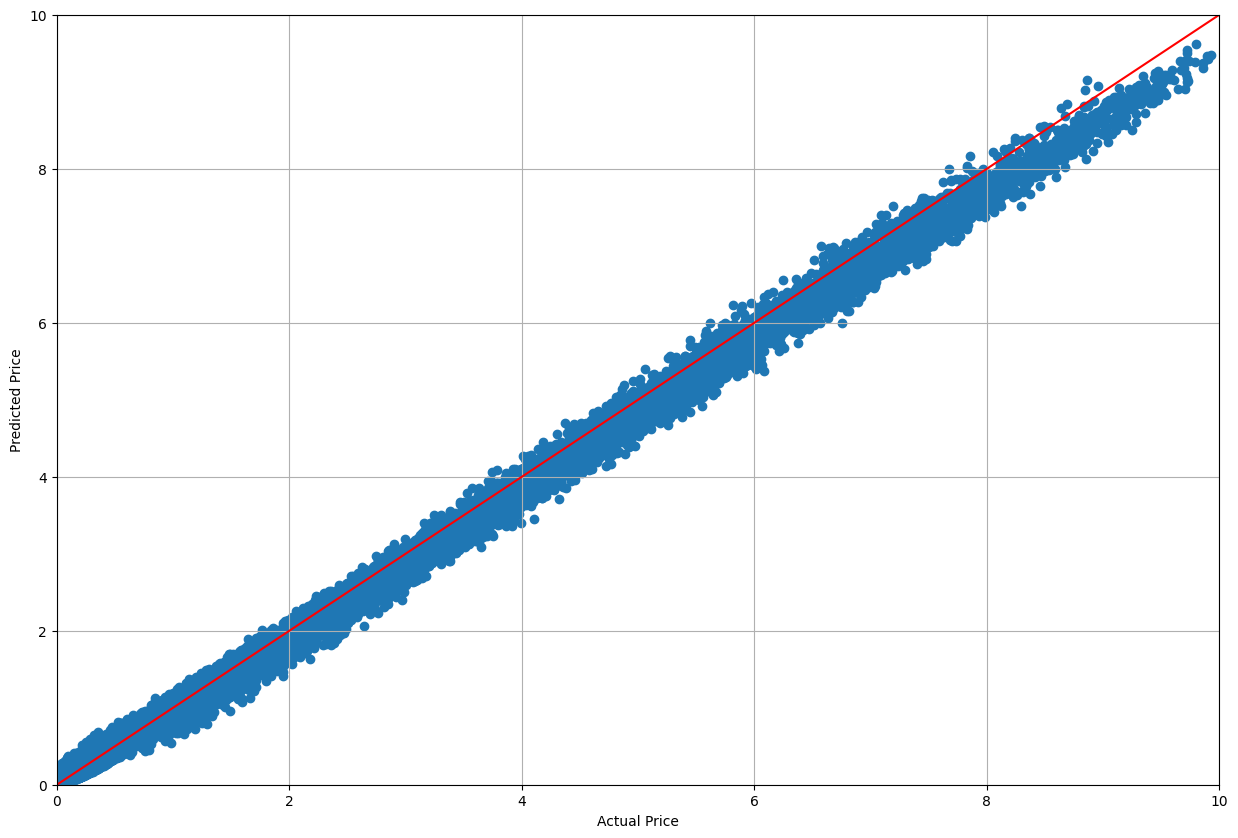

In [75]:
#out sample(20)
plt.figure(figsize = (15,10))
plt.scatter((y_test+0.5)*10, (predictions+0.5)*10)
plt.axis((0, 10, 0, 10))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,10], [0,10], 'r')
plt.grid(True)

In [76]:
InSamplePredictions = model.predict(X_train)

6888/6888 [==============================] - 13s 2ms/step


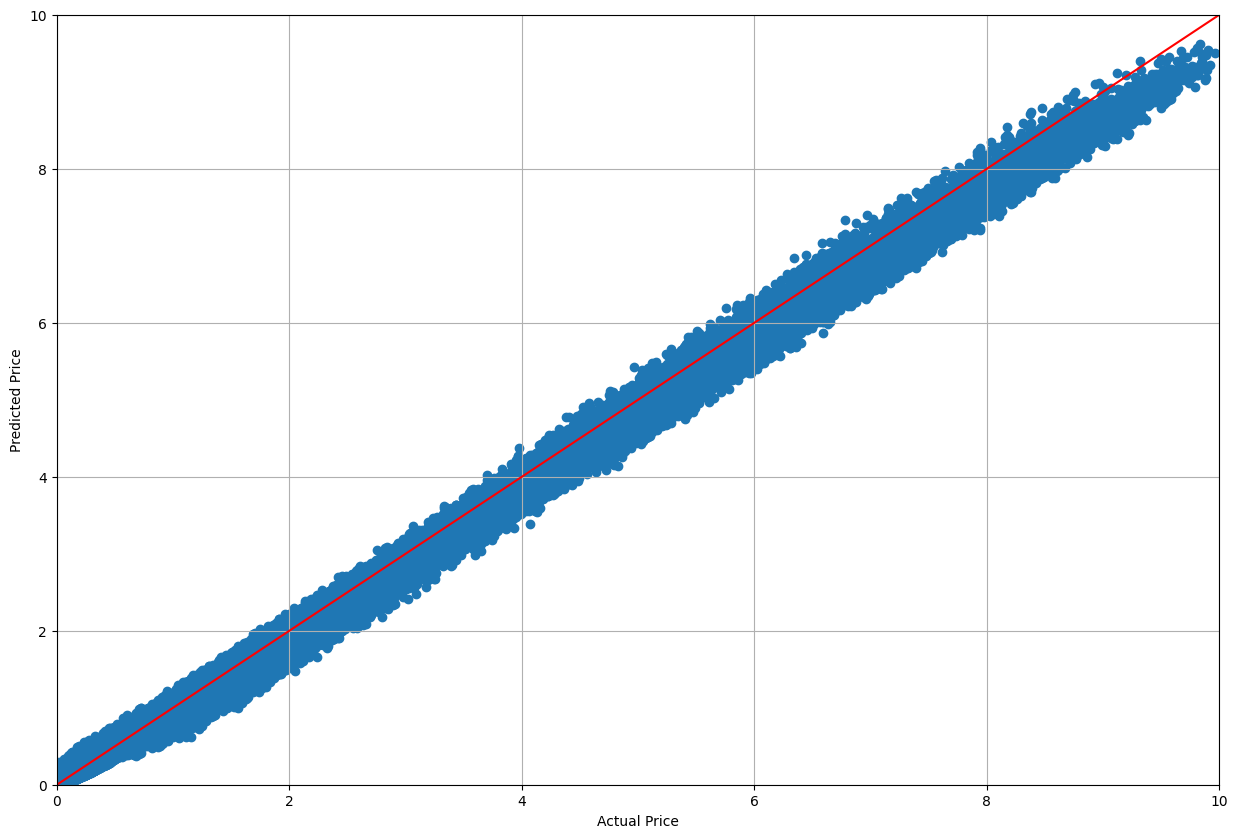

In [77]:
#in sample (80)
plt.figure(figsize = (15,10))
plt.scatter((y_train+0.5)*10, (InSamplePredictions+0.5)*10)
plt.axis((0, 10, 0, 10))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,10], [0,10], 'r')
plt.grid(True)